#### Imports and Downloads

In [ ]:
# !pip install textacy
# !pip install transformers
# !pip install sentence-transformers
# !pip install top2vec
# !pip install pandas scikit-learn

In [ ]:
import pandas as pd
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
from textacy.preprocessing.remove import punctuation
import matplotlib.pyplot as plt
import numpy as np
import sklearn

from sklearn.feature_extraction.text import CountVectorizer

from gensim.parsing.preprocessing import remove_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import re

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
from typing import List
from sklearn.decomposition import NMF

import spacy
from spacy import displacy
import pandas as pd

from wordcloud import WordCloud

from top2vec import Top2Vec

from transformers import BertTokenizer, BertForSequenceClassification, pipeline
import torch

spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


#### Import Dataset

In [ ]:
disney = pd.read_csv('DisneylandReviews.csv', encoding='latin-1',on_bad_lines='skip')


#### Data Cleaning

In [ ]:
# taking off Disneyland from branch name as all branches are Disney locations

for i in range(len(disney['Branch'])):
  if disney.Branch[i] == 'Disneyland_Paris':
    disney.Branch[i] = 'Paris'
  elif disney.Branch[i] == 'Disneyland_California':
    disney.Branch[i] = 'California'
  else:
    disney.Branch[i] = 'HongKong'

<ipython-input-24-fdb0fb58ff65>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disney.Branch[i] = 'HongKong'
<ipython-input-24-fdb0fb58ff65>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disney.Branch[i] = 'California'
<ipython-input-24-fdb0fb58ff65>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disney.Branch[i] = 'Paris'


In [ ]:
# checking to make sure there are no NA values to impute
for i in disney.columns:
  print(i, 'nulls: ', disney[i].isna().sum())

Review_ID nulls:  0
Rating nulls:  0
Year_Month nulls:  0
Reviewer_Location nulls:  0
Review_Text nulls:  0
Branch nulls:  0


In [ ]:
# removing punctuation
disney['Review_Text'] = disney['Review_Text'].apply(punctuation)

# Convert to lowercase 
disney['Review_Text'] = disney['Review_Text'].map(lambda x: x.lower())

# Replace common entities/concepts 
disney['Review_Text'] = disney['Review_Text'].\
 apply(urls).\
 apply(hashtags).\
 apply(currency_symbols).\
 apply(emojis).\
 apply(emails)

In [ ]:
# removing stopwords from gensim's library

for index, row in disney.iterrows():
  row['Review_Text'] = remove_stopwords(row['Review_Text'])

In [ ]:
# using the 1-5 ratings given by customers to create a positive/negative review sentiment 

disney['rating_sentiment'] = ''
for i in range(len(disney)):
  if disney['Rating'][i] >= 3:
    disney['rating_sentiment'][i] = 'POSITIVE'
  else:
    disney['rating_sentiment'][i] = 'NEGATIVE'

<ipython-input-28-19ace667c720>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disney['rating_sentiment'][i] = 'POSITIVE'
<ipython-input-28-19ace667c720>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disney['rating_sentiment'][i] = 'NEGATIVE'


In [ ]:
# seeing most frequent words to determine what to regex

vec = CountVectorizer(stop_words="english", binary=True).fit(disney['Review_Text'])
bag_of_words = vec.transform(disney['Review_Text'])
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
words_freq[0:20]

[('park', 21427),
 ('rides', 20678),
 ('disneyland', 19798),
 ('disney', 18986),
 ('time', 17744),
 ('day', 16478),
 ('great', 12079),
 ('just', 11073),
 ('food', 10629),
 ('place', 10490),
 ('ride', 10196),
 ('kids', 9579),
 ('good', 9497),
 ('visit', 9065),
 ('like', 8690),
 ('really', 8618),
 ('went', 8413),
 ('long', 8285),
 ('fun', 8044),
 ('people', 7419)]

From the top 10 words, you can see that Disneyland and Disney are being treated as two separate words and therefore dulling the signal from this word. Decided to standardize it and the name variations of different locations.  

In [ ]:
# lots of Disney vs. Disneyland -- helps to standardize
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(Disney\s?land|Disney\s?world)\b', 'Disney', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(Hong Kong|HK)\b', 'HongKong', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(Los Angeles|LA)\b', 'LosAngeles', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(Paris|Euro\s?Disney)\b', 'Paris', regex=True, flags=re.IGNORECASE)

In [ ]:
# regex to make rides one word 
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(it\'s a small word|its a small world )\b', 'ITS_A_SMALL_WORLD', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(big )?thunder (mtn|mountain)( railroad)?\b', 'THUNDER_MTN', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(space) (mtn|mountain)\b', 'SPACE_MTN', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(Indiana Jones|Indiana)\b', 'INDIANA_JONES', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b((The )?Haunted Mansion|HM|Haunted Mansuon)\b', 'THE_HAUNTED_MANSION', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(Pirates of the Caribbean|Pirates)\b', 'PIRATES_OF_THE_CARIBBEAN', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(Matterhorn Bobsleds|Matterhorn)\b', 'MATTERHORN_BOBSLEDS', regex=True, flags=re.IGNORECASE)

disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(splash) (mtn|mountain)\b', 'SPLASH_MTN', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(Toy Story Parachute( Ride)?|parachute( drop)?( ride)?)\b', 'TOY_STORY_PARACHUTE', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(Grizzly( river)? run|Grizzly river( ride)?)\b', 'GRIZZLY_RIVER_RUN', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r'\b(Big Grizzly)?(Mountain|mtn)? runaway mine cars\b', 'RUNAWAY_MINE_CARS', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r"\b(Aerosmith( ride)?|Aeromosmith Rock and Roller Coaster|Aerosmith coaster|aerosmith rock 'n' roller|aerosmith rock and rollercoaster|aerosmith rock'nd? roller(coaster)?|rock'n roll coaster aerosmith|Aerosmith( coaster)?)\b", 'AEROMSITH_ROCKNROLLER', regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r"\b(crush's coasters?)\b", "CRUSH'S_COASTER", regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r"\b(buzz|buzz lightyear|buzz light( yr| years?)?)\b", "BUZZ_LIGHTYEAR", regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r"\b(dumbo the flying elephants?|flying dumbo elephants?|flying elephants?|dumbo flying elephants?|dumbo's elephants?|dumbo)\b", "DUMBO_FLYING_ELEPHANT", regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r"\b(Le Temple du Peril|(the )?temple of peril)\b", "TEMPLE_OF_PERIL", regex=True, flags=re.IGNORECASE)
disney['Review_Text'] = disney['Review_Text'].str.replace(r"\b(terror tower|tower of terror)\b", "TOWER_OF_TERROR", regex=True, flags=re.IGNORECASE)


In [ ]:
# regex grouping for people
partners = 'wife|husband|wifey|spouse|girlfriend|\\bgf\\b|boyfriend|\\bbf\\b'
parent = '|mom|dad|grand \w+|grand?(daughter\w?|son\w?|mother\w?|father\w?|parent\w?|kid\w?|child\w*)'
relatives = '|\\bsister\\b|brother\w?\\b|\\bsis\\b|\\bbro\\b|cousin'
side_parents = '|\\baunt\w*\b|\\buncle\\b'
kids = '|\\bdaughter|\\bson\w?\\b|toddler|kid\w?|\\bchildren\\b|my\s?(\\bboy\w*\\b|\\bgirl\w*\\b)'
age_kids = '|\\b\w+ year old\\b|\\b\w+\syr?(\w+ old)\\b|\\b\w+yr?(\w+ old)\\b'
side_kids = '|god?(\w daughter|\wdaughter|\wson|\w son|\w child|\wchild)|niece|nephew'
others = '|family|families|friends?|best\s?friends?'
visitors_regex = partners + parent + relatives + side_parents + kids + age_kids + side_kids + others

disney['Review_Text'] = disney['Review_Text'].str.replace(r'({})'.format(visitors_regex), "VISITOR", regex=True, flags = re.IGNORECASE)


In [ ]:
disney = disney.sample(1000, random_state=42).reset_index() # getting sample to make deataset more manageable

# lemmatize the review column
def lemmatize(doc: str):
    return " ".join([token.lemma_ for token in nlp(doc)])

disney['lemma_reviews'] = disney.Review_Text.apply(lemmatize)

#### Sentiment Analysis Model


In [ ]:
disney_sample = disney.sample(500).reset_index()
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [ ]:
# running the sentiment classifier on each line of reviews and creating the predictions based on that
disney_sample['sentiment_pred'] = ''

for i in range(len(disney_sample)):
  disney_sample['sentiment_pred'][i] = list(classifier(disney_sample['lemma_reviews'][i][:512])[0].values())[0]

review_sentiment_pred = list(disney_sample['sentiment_pred'])
true_rating = list(disney_sample['rating_sentiment'])

<ipython-input-35-1b9ee69ba000>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disney_sample['sentiment_pred'][i] = list(classifier(disney_sample['lemma_reviews'][i][:512])[0].values())[0]


In [ ]:
print(confusion_matrix(true_rating, review_sentiment_pred))

# print('f1 score:', f1_score(true_rating, review_sentiment_pred, labels=None, pos_label=1, average='weighted', sample_weight=None, zero_division='warn'))

TP = 0
FP = 0
TN = 0
FN = 0

for i in range(len(disney_sample)):
  if disney_sample['rating_sentiment'][i] == 'POSITIVE' and disney_sample['sentiment_pred'][i] == 'POSITIVE':
    TP += 1
  elif disney_sample['rating_sentiment'][i] == 'NEGATIVE' and disney_sample['sentiment_pred'][i] == 'NEGATIVE':
    TN += 1
  elif disney_sample['rating_sentiment'][i] == 'NEGATIVE' and disney_sample['sentiment_pred'][i] == 'POSITIVE':
    FP += 1
  elif disney_sample['rating_sentiment'][i] == 'POSITIVE' and disney_sample['sentiment_pred'][i] == 'NEGATIVE':
    FN += 1

precision = (TP)/ (TP +FP)
recall = (TP)/ (TP + FN)
print('accuracy:', (TP + TN)/ (TN + TP + FN + FP))
print('precision:', precision)
print('recall:', recall)
print('f1 score: ', 2 * ((precision * recall)/(precision + recall)))

[[ 35   8]
 [118 339]]
accuracy: 0.748
precision: 0.9769452449567724
recall: 0.7417943107221007
f1 score:  0.8432835820895523


#### Logistic Regression for Sentiment Analysis

In [ ]:
# countvectorizer
count_vec = CountVectorizer(ngram_range = (2, 2), stop_words="english", binary=True)
X_c = count_vec.fit_transform(disney["lemma_reviews"]) # using a sample instead of entire dataset
count_vec_df = pd.DataFrame(X_c.toarray(), columns=count_vec.get_feature_names_out())

X_c = count_vec.fit_transform(disney['lemma_reviews'])

y = disney['rating_sentiment']

X_c_train, X_c_test, y_c_train, y_c_test = train_test_split(X_c, y, random_state = 0)

logistic_regression_c = LogisticRegression(max_iter=10000)
logistic_regression_c.fit(X_c_train, y_c_train)
training_predictions_c = logistic_regression_c.predict(X_c_train)
test_predictions_c = logistic_regression_c.predict(X_c_test)
y_c_probabilities = logistic_regression_c.predict_proba(X_c_test)

print('model prediction for first 5 docs in training: \n', training_predictions_c[:5])
print('\nconfusion matrix for training\n', confusion_matrix(y_c_train, training_predictions_c))
print('confusion matrix for testing\n', confusion_matrix(y_c_test, test_predictions_c))
print('\nlogistic regression training score: ', logistic_regression_c.score(X_c_train, y_c_train))
print('logistic regression test score: ', logistic_regression_c.score(X_c_test, y_c_test))

print('accuracy:', sklearn.metrics.accuracy_score(y_c_test, test_predictions_c, normalize=True, sample_weight=None))
print('precision:', sklearn.metrics.precision_score(y_c_test, test_predictions_c, labels=None, pos_label = 1, average='weighted', sample_weight=None, zero_division='warn'))
print('recall:', sklearn.metrics.recall_score(y_c_test, test_predictions_c, labels=None, pos_label = 1, average='weighted', sample_weight=None, zero_division='warn'))
print('f1 score:', f1_score(y_c_test, test_predictions_c, labels=None, pos_label=1, average='weighted', sample_weight=None, zero_division='warn'))

model prediction for first 5 docs in training: 
 ['POSITIVE' 'NEGATIVE' 'POSITIVE' 'POSITIVE' 'POSITIVE']

confusion matrix for training
 [[ 79   0]
 [  0 671]]
confusion matrix for testing
 [[  0  19]
 [  0 231]]

logistic regression training score:  1.0
logistic regression test score:  0.924
accuracy: 0.924
precision: 0.8537760000000001
recall: 0.924
f1 score: 0.8875010395010396


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# tfidf
TDidf_vec = TfidfVectorizer(ngram_range = (2, 2), token_pattern=r'\b[a-zA-Z]{3,}\b')
corpus = list(disney["lemma_reviews"].values)  # using a sample instead of entire dataset
X_t = TDidf_vec.fit_transform(corpus)
terms = TDidf_vec.get_feature_names_out()
tf_idf = pd.DataFrame(X_t.toarray(), columns = terms)

corpus = list(disney["lemma_reviews"].values)
X_t = TDidf_vec.fit_transform(corpus)

X_t_train, X_t_test, y_t_train, y_t_test = train_test_split(X_t, y, random_state = 0)

logistic_regression_t = LogisticRegression(max_iter=10000)
logistic_regression_t.fit(X_t_train, y_t_train)
training_predictions_t = logistic_regression_t.predict(X_t_train)
test_predictions_t = logistic_regression_t.predict(X_t_test)
y_t_probabilities = logistic_regression_t.predict_proba(X_t_test)

print('model prediction for first 5 docs in training: \n', training_predictions_t[:5])
print('\nconfusion matrix for training\n', confusion_matrix(y_t_train, training_predictions_t))
print('confusion matrix for testing\n', confusion_matrix(y_t_test, test_predictions_t))
print('\nlogistic regression training score: ', logistic_regression_t.score(X_t_train, y_t_train))
print('logistic regression test score: ', logistic_regression_t.score(X_t_test, y_t_test))
print('accuracy:', sklearn.metrics.accuracy_score(y_t_test, test_predictions_t, normalize=True, sample_weight=None))
print('precision:', sklearn.metrics.precision_score(y_t_test, test_predictions_t, labels=None, pos_label = 1, average='weighted', sample_weight=None, zero_division='warn'))
print('recall:', sklearn.metrics.recall_score(y_t_test, test_predictions_t, labels=None, pos_label = 1, average='weighted', sample_weight=None, zero_division='warn'))
print('f1 score:', f1_score(y_t_test, test_predictions_t, labels=None, pos_label=1, average='weighted', sample_weight=None, zero_division='warn'))

model prediction for first 5 docs in training: 
 ['POSITIVE' 'POSITIVE' 'POSITIVE' 'POSITIVE' 'POSITIVE']

confusion matrix for training
 [[  0  79]
 [  0 671]]
confusion matrix for testing
 [[  0  19]
 [  0 231]]

logistic regression training score:  0.8946666666666667
logistic regression test score:  0.924
accuracy: 0.924
precision: 0.8537760000000001
recall: 0.924
f1 score: 0.8875010395010396


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# word2vec
def word2_vec(processed_text):
    return np.array(nlp(processed_text).vector)

disney["vectors"] = disney.lemma_reviews.apply(word2_vec)

X_w = np.array([vector for vector in disney["vectors"]])
y = disney["rating_sentiment"]

X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_w, y, random_state = 0)

logistic_regression_w = LogisticRegression(max_iter=10000)
logistic_regression_w.fit(X_w_train, y_w_train)
training_predictions_w = logistic_regression_w.predict(X_w_train)
y_w_probabilities = logistic_regression_w.predict_proba(X_w_test)
test_predictions_w = logistic_regression_w.predict(X_w_test)

print('model prediction for first 5 docs in training: \n', training_predictions_w[:5])
print('\nconfusion matrix for training\n', confusion_matrix(y_w_train, training_predictions_w))
print('confusion matrix for testing\n', confusion_matrix(y_w_test, test_predictions_w))
print('\nlogistic regression training score: ', logistic_regression_w.score(X_w_train, y_w_train))
print('logistic regression testing score: ', logistic_regression_w.score(X_w_test, y_w_test))

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html 
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html

print('accuracy:', sklearn.metrics.accuracy_score(y_w_test, test_predictions_w, normalize=True, sample_weight=None))
print('precision:', sklearn.metrics.precision_score(y_w_test, test_predictions_w, labels=None, pos_label = 1, average='weighted', sample_weight=None, zero_division='warn'))
print('recall:', sklearn.metrics.recall_score(y_w_test, test_predictions_w, labels=None, pos_label = 1, average='weighted', sample_weight=None, zero_division='warn'))
print('f1 score:', f1_score(y_w_test, test_predictions_w, labels=None, pos_label=1, average='weighted', sample_weight=None, zero_division='warn'))

model prediction for first 5 docs in training: 
 ['POSITIVE' 'POSITIVE' 'POSITIVE' 'POSITIVE' 'POSITIVE']

confusion matrix for training
 [[  1  78]
 [  0 671]]
confusion matrix for testing
 [[  0  19]
 [  0 231]]

logistic regression training score:  0.896
logistic regression testing score:  0.924
accuracy: 0.924
precision: 0.8537760000000001
recall: 0.924
f1 score: 0.8875010395010396


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Our team acknowleges that the accuracy, precision, recall, and F1 scores were the same among the Word2Vec, Count Vectorizer, and TFIDF logistic regression models. There is a class imbalance problem that we were unable to solve due as we needed to sample to a small sample size of 500 in order for the code to run without crashing. 

#### Creating Subsets of Data to Conduct Topic Modeling

In [ ]:
# segmenting based on positive and negative reviews
disney_pos = disney[disney['rating_sentiment'] == 'POSITIVE']
disney_neg = disney[disney['rating_sentiment'] == 'NEGATIVE']

In [ ]:
# segmenting positive reviews into the three branches
disney_pos_CA = disney_pos[disney['Branch'] == 'California']
disney_pos_HK = disney_pos[disney['Branch'] == 'HongKong']
disney_pos_PAR = disney_pos[disney['Branch'] == 'Paris']

# segmenting the negative locations into three branches
disney_neg_CA = disney_neg[disney['Branch'] == 'California']
disney_neg_HK = disney_neg[disney['Branch'] == 'HongKong']
disney_neg_PAR = disney_neg[disney['Branch'] == 'Paris']

<ipython-input-42-062b002534d4>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  disney_pos_CA = disney_pos[disney['Branch'] == 'California']
<ipython-input-42-062b002534d4>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  disney_pos_HK = disney_pos[disney['Branch'] == 'HongKong']
<ipython-input-42-062b002534d4>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  disney_pos_PAR = disney_pos[disney['Branch'] == 'Paris']
<ipython-input-42-062b002534d4>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  disney_neg_CA = disney_neg[disney['Branch'] == 'California']
<ipython-input-42-062b002534d4>:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  disney_neg_HK = disney_neg[disney['Branch'] == 'HongKong']
<ipython-input-42-062b002534d4>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  disney_neg_PAR = disney_n

#### Topic Modelling with TFIDF Vectors

In [ ]:
# function for getting top tokens
def get_top_tf_idf_tokens_for_topic(H: np.array, feature_names: List[str], num_top_tokens: int = 5):
  """
  Uses the H matrix (K components x M original features) to identify for each
  topic the most frequent tokens.
  """
  for topic, vector in enumerate(H):
    print(f"TOPIC {topic}\n")
    total = vector.sum()
    top_scores = vector.argsort()[::-1][:num_top_tokens]
    token_names = list(map(lambda idx: feature_names[idx], top_scores))
    strengths = list(map(lambda idx: vector[idx] / total, top_scores))
    
    for strength, token_name in zip(strengths, token_names):
      print(f"\b{token_name} ({round(strength * 100, 1)}%)\n")
    print(f"=" * 50)

# function for getting top documents for each token 
def get_top_documents_for_each_topic(W: np.array, documents: List[str], num_docs: int = 5):
  sorted_docs = W.argsort(axis=0)[::-1]
  top_docs = sorted_docs[:num_docs].T
  per_document_totals = W.sum(axis=1)
  for topic, top_documents_for_topic in enumerate(top_docs):
    print(f"Topic {topic}")
    for doc in top_documents_for_topic:
      score = W[doc][topic]
      percent_about_topic = round(score / per_document_totals[doc] * 100, 1)
      print(f"{percent_about_topic}%", documents[doc])
    print("=" * 50)

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(2,2), stop_words="english")
nmf = NMF(n_components=3)

##### POSITIVE REVIEWS

In [ ]:
# topic modeling for CA positive reviews
X_reviews_pos_CA, reviews_pos_CA_terms = vectorizer.fit_transform(disney_pos_CA.lemma_reviews), vectorizer.get_feature_names_out()
reviews_pos_CA_tf_idf = pd.DataFrame(X_reviews_pos_CA.toarray(), columns = reviews_pos_CA_terms)

W_reviews_pos_CA = nmf.fit_transform(X_reviews_pos_CA)
H_reviews_pos_CA = nmf.components_

print('topic modeling: ')
get_top_tf_idf_tokens_for_topic(H_reviews_pos_CA, reviews_pos_CA_tf_idf.columns.tolist(), 5)

print('top documents: ')
get_top_documents_for_each_topic(W_reviews_pos_CA, disney_pos_CA.lemma_reviews.tolist())

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


topic modeling: 
TOPIC 0

fast pass (0.8%)

great time (0.3%)

california adventure (0.3%)

day disney (0.3%)

spend day (0.2%)

TOPIC 1

place earth (2.0%)

happy place (1.8%)

visitor spend (0.6%)

say happy (0.4%)

good place (0.4%)

TOPIC 2

love disney (0.7%)

visit disney (0.6%)

visitor visitor (0.5%)

great visitor (0.4%)

ride ride (0.3%)

top documents: 
Topic 0
100.0% I take my VISITOR to Disney in late july and it be everything we could have imagine and more    we buy the 3 day park hopper which be just about enough time to visit everything Disney    california adventure have to offer   I think next time I will get the 4 day but 3 day be about enough   it be certainly 3 fun fill day   especially for my VISITOR   yes it be crowd but that s to be expect   you will still have enough time to pretty much see everything with the 3 day park hopper   the fast pass be cool because for example splash_mtn have a wait time of 60 minute so we get a fast pass and it tell y

In [ ]:
# topic modeling for positive Hong Kong reviews
X_reviews_pos_HK, reviews_pos_HK_terms = vectorizer.fit_transform(disney_pos_HK.lemma_reviews), vectorizer.get_feature_names_out()
reviews_pos_HK_tf_idf = pd.DataFrame(X_reviews_pos_HK.toarray(), columns = reviews_pos_HK_terms)

W_reviews_pos_HK = nmf.fit_transform(X_reviews_pos_HK)
H_reviews_pos_HK = nmf.components_

print('topic modeling: ')
get_top_tf_idf_tokens_for_topic(H_reviews_pos_HK, reviews_pos_HK_tf_idf.columns.tolist(), 5)

print('top documents: ')
get_top_documents_for_each_topic(W_reviews_pos_HK, disney_pos_HK.lemma_reviews.tolist())

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


topic modeling: 
TOPIC 0

hongkong disney (1.3%)

visit hongkong (0.6%)

theme park (0.5%)

disney small (0.4%)

happy place (0.3%)

TOPIC 1

disney park (1.1%)

small disney (0.5%)

disney hongkong (0.4%)

disney easy (0.3%)

really good (0.2%)

TOPIC 2

visitor enjoy (0.4%)

wait time (0.4%)

visitor love (0.3%)

day pass (0.3%)

ride great (0.3%)

top documents: 
Topic 0
98.3% I always love to visit this place at anytime and repeatedly watch show and the firework display at end    each time I have VISITOR or VISITOR visit HongKong   Disney not to be miss    
100.0% visit HongKong Disney last august 2014 and it be a dream come true   I love everything about the place   really a worth it experience     stay until the firework cause it really a spectacular to watch   no firework display here in the philippine can compare to what Disney firework show offer   one thing I do not like during our visit be the weather     it be really hot   good month to travel HongKong Disney

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
# topic modeling for positive Paris reviews
X_reviews_pos_PAR, reviews_pos_PAR_terms = vectorizer.fit_transform(disney_pos_PAR.lemma_reviews), vectorizer.get_feature_names_out()
reviews_pos_PAR_tf_idf = pd.DataFrame(X_reviews_pos_PAR.toarray(), columns = reviews_pos_PAR_terms)

W_reviews_pos_PAR = nmf.fit_transform(X_reviews_pos_PAR)
H_reviews_pos_PAR = nmf.components_

print('topic modeling: ')
get_top_tf_idf_tokens_for_topic(H_reviews_pos_PAR, reviews_pos_PAR_tf_idf.columns.tolist(), 5)

print('top documents: ')
get_top_documents_for_each_topic(W_reviews_pos_PAR, disney_pos_PAR.lemma_reviews.tolist())

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


topic modeling: 
TOPIC 0

disney paris (0.3%)

disney hotel (0.2%)

young visitor (0.2%)

visitor love (0.2%)

visitor visitor (0.2%)

TOPIC 1

disney park (2.0%)

time disney (0.4%)

park disney (0.4%)

park world (0.3%)

big disappointment (0.3%)

TOPIC 2

fast pass (1.6%)

use fast (0.4%)

pass time (0.4%)

pass ticket (0.3%)

enjoy ride (0.3%)

top documents: 
Topic 0
58.3% Disney be the most magical place in the world   there be 7 disney hotel all with different theme   the hotel be all excellent and the name of they be   in order of quality   1   Disney hotel   standard room   VISITOR room   castle club room and suit 2   disney s hotel new york   standard room   empire state club room and suit 3   disney s newport bay club   standard room   admiral s floor room   admiral s floor VISITOR room and suit 4   disney s sequoia lodge   standard room   montana room   golden forest club room and honeymoon suite 5   disney s hotel cheyenne   standard room   rio grande room a

##### NEGATIVE REVIEWS

In [ ]:
# topic modeling for negative California reviews
X_reviews_neg_CA, reviews_neg_CA_terms = vectorizer.fit_transform(disney_neg_CA.lemma_reviews), vectorizer.get_feature_names_out()
reviews_neg_CA_tf_idf = pd.DataFrame(X_reviews_neg_CA.toarray(), columns = reviews_neg_CA_terms)

W_reviews_neg_CA = nmf.fit_transform(X_reviews_neg_CA)
H_reviews_neg_CA = nmf.components_

print('topic modeling: ')
get_top_tf_idf_tokens_for_topic(H_reviews_neg_CA, reviews_neg_CA_tf_idf.columns.tolist(), 5)

print('top documents: ')
get_top_documents_for_each_topic(W_reviews_neg_CA, disney_neg_CA.lemma_reviews.tolist())

topic modeling: 
TOPIC 0

fast pass (1.1%)

wait line (0.7%)

line long (0.6%)

long ride (0.5%)

little visitor (0.4%)

TOPIC 1

visitor visitor (1.1%)

wait time (1.0%)

end day (0.7%)

time ride (0.6%)

look forward (0.5%)

TOPIC 2

disney park (0.6%)

day park (0.6%)

park day (0.5%)

california adventure (0.4%)

ride really (0.4%)

top documents: 
Topic 0
98.0% we take out 5 and VISITOR boy to disney and we get there both time when the park open   I be run from one ride to another strategically plan how to get a fast pass and not have the VISITOR wait in line for so long   not every ride have a fast pass so      at one point we wait in line for 90 min for a ride   the food be not that great there thank god we pack snack and overall I be disspointe b c we do not get one single picture w   a character   the line each time be sooo long it be unreal   why would you have this so long for impatient VISITOR   the adult that be visit the park be very inconsierate of VISITOR

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
# topic modeling for negative Hong Kong reviews
X_reviews_neg_HK, reviews_neg_HK_terms = vectorizer.fit_transform(disney_neg_HK.lemma_reviews), vectorizer.get_feature_names_out()
reviews_neg_HK_tf_idf = pd.DataFrame(X_reviews_neg_HK.toarray(), columns = reviews_neg_HK_terms)

W_reviews_neg_HK = nmf.fit_transform(X_reviews_neg_HK)
H_reviews_neg_HK = nmf.components_

print('topic modeling: ')
get_top_tf_idf_tokens_for_topic(H_reviews_neg_HK, reviews_neg_HK_tf_idf.columns.tolist(), 5)

print('top documents: ')
get_top_documents_for_each_topic(W_reviews_neg_HK, disney_neg_HK.lemma_reviews.tolist())

topic modeling: 
TOPIC 0

cut line (4.0%)

park attendant (2.9%)

birthday ignore (2.6%)

ignore hear (2.6%)

attendant cut (2.6%)

TOPIC 1

ocean park (4.2%)

disney california (3.3%)

time money (3.2%)

spend ocean (3.2%)

hotel island (3.2%)

TOPIC 2

ride ride (0.9%)

just long (0.9%)

minute ride (0.9%)

queue hour (0.9%)

queue just (0.9%)

top documents: 
Topic 0
100.0% we be in line for the picture session with mickey when they park attendant cut the line and say that it s over   I request for at least one shot as it be my VISITOR s birthday but I be ignore and it be as if I be not hear
100.0% the themepark be great   it be not disney s fault that the visitor be rude and unorderly   VISITOR and adult try to push past we to cut in line every minute of the day   will not return
100.0% prepay for a 2 day ticket but be only issue a 1 day ticket at the park   cost we 2 hour to fix at the gate on the second day with a visitor which be so cranky after wait that long in 

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
# topic modeling for negative Paris reviews
X_reviews_neg_PAR, reviews_neg_PAR_terms = vectorizer.fit_transform(disney_neg_PAR.lemma_reviews), vectorizer.get_feature_names_out()
reviews_neg_PAR_tf_idf = pd.DataFrame(X_reviews_neg_PAR.toarray(), columns = reviews_neg_PAR_terms)

W_reviews_neg_PAR = nmf.fit_transform(X_reviews_neg_PAR)
H_reviews_neg_PAR = nmf.components_

print('topic modeling: ')
get_top_tf_idf_tokens_for_topic(H_reviews_neg_PAR, reviews_neg_PAR_tf_idf.columns.tolist(), 5)

print('top documents: ')
get_top_documents_for_each_topic(W_reviews_neg_PAR, disney_neg_PAR.lemma_reviews.tolist())

topic modeling: 
TOPIC 0

disney paris (0.5%)

theme park (0.3%)

fast pass (0.2%)

disney park (0.2%)

visit disney (0.2%)

TOPIC 1

fast track (1.1%)

visitor visitor (1.0%)

ride close (0.7%)

track ticket (0.6%)

pay extra (0.5%)

TOPIC 2

big ride (1.6%)

ride weren (1.6%)

staff ride (1.1%)

visitor want (1.1%)

maintain ride (0.9%)

top documents: 
Topic 0
100.0% where do you start       firstly if you only read one bit of my review then go to florida instead   it be 100   well   we ve be twice there and it be a different league and cheap aswell back to les miserable or disney Paris      the park be hugely overcrowded   everyone other than the brit be rude which be something I never think I d say   the brit stand out as be polite when quee for ride or the bus   they   the italians   french and portugese   do not know what a que be   be arrogant and don t care if they physically push your VISITOR out of the way to get to a ride first   we watch an old french couple

/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
# revision for topic modeling negative Paris reviews -- took away some words that were distorting signal
disney_neg_PAR['lemma_reviews1'] = disney_neg_PAR['lemma_reviews'].str.replace(r'\b(vistor|visit|disney|paris|florida)\b', '', regex=True, flags=re.IGNORECASE)

X_reviews_neg_PAR1, reviews_neg_PAR_terms1 = vectorizer.fit_transform(disney_neg_PAR.lemma_reviews1), vectorizer.get_feature_names_out()
reviews_neg_PAR_tf_idf1 = pd.DataFrame(X_reviews_neg_PAR1.toarray(), columns = reviews_neg_PAR_terms1)

W_reviews_neg_PAR1 = nmf.fit_transform(X_reviews_neg_PAR1)
H_reviews_neg_PAR1 = nmf.components_

print('topic modeling: ')
get_top_tf_idf_tokens_for_topic(H_reviews_neg_PAR1, reviews_neg_PAR_tf_idf1.columns.tolist(), 5)

print('top documents: ')
get_top_documents_for_each_topic(W_reviews_neg_PAR1, disney_neg_PAR.lemma_reviews.tolist())

topic modeling: 
TOPIC 0

ride close (1.6%)

waste money (0.9%)

staff lot (0.8%)

money advise (0.8%)

smelly rude (0.8%)

TOPIC 1

theme park (0.4%)

people smoke (0.4%)

fast pass (0.4%)

ride weren (0.4%)

big ride (0.4%)

TOPIC 2

fast track (1.2%)

visitor visitor (0.9%)

track ticket (0.7%)

pay extra (0.6%)

ride break (0.4%)

top documents: 
Topic 0
100.0% easter sunday we take our VISITOR to Paris Disney for her tenth birthday   start our experience in a dirty cafe with hardly any seating and a awful coffee    muffin and hot chocolate so hot my VISITOR burn t her mouth   first ride be close   second ride close   pocahonta playground be lame   next stop   orbitron 1hour wait for a ride that take under two minute   take ten minute to buy two pack of crisps when there be only two people ahead of I   the food be serve look so plastic   all we want be some sandwich   we leave starve   everywhere we go ride be close    include space_mtn   the ride that be open have w

<ipython-input-51-e0084680514d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disney_neg_PAR['lemma_reviews1'] = disney_neg_PAR['lemma_reviews'].str.replace(r'\b(vistor|visit|disney|paris|florida)\b', '', regex=True, flags=re.IGNORECASE)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [ ]:
# revision for topic modeling negative Hong Kong reviews -- took away some words that were distorting signal

disney_neg_HK['lemma_reviews1'] = disney_neg_HK['lemma_reviews'].str.replace(r'\b(visitor|visit|disney|hk|hongkong|tokyoe|really)\b', '', regex=True, flags=re.IGNORECASE)

X_reviews_neg_HK1, reviews_neg_HK_terms1 = vectorizer.fit_transform(disney_neg_HK.lemma_reviews1), vectorizer.get_feature_names_out()
reviews_neg_HK_tf_idf1 = pd.DataFrame(X_reviews_neg_HK1.toarray(), columns = reviews_neg_HK_terms1)

W_reviews_neg_HK1 = nmf.fit_transform(X_reviews_neg_HK1)
H_reviews_neg_HK1 = nmf.components_

print('topic modeling: ')
get_top_tf_idf_tokens_for_topic(H_reviews_neg_HK1, reviews_neg_HK_tf_idf1.columns.tolist(), 5)

print('top documents: ')
get_top_documents_for_each_topic(W_reviews_neg_HK1, disney_neg_HK.lemma_reviews.tolist())

topic modeling: 
TOPIC 0

cut line (4.7%)

park attendant (3.1%)

say request (2.9%)

line say (2.9%)

shot birthday (2.9%)

TOPIC 1

ocean park (4.7%)

expensive disappointment (3.5%)

especially hotel (3.5%)

spend ocean (3.5%)

park especially (3.5%)

TOPIC 2

leave pm (1.2%)

tell outdoor (1.1%)

outdoor ride (1.1%)

ride open (1.1%)

multiple time (1.1%)

top documents: 
Topic 0
100.0% we be in line for the picture session with mickey when they park attendant cut the line and say that it s over   I request for at least one shot as it be my VISITOR s birthday but I be ignore and it be as if I be not hear
100.0% the themepark be great   it be not disney s fault that the visitor be rude and unorderly   VISITOR and adult try to push past we to cut in line every minute of the day   will not return
100.0% prepay for a 2 day ticket but be only issue a 1 day ticket at the park   cost we 2 hour to fix at the gate on the second day with a visitor which be so cranky after wait

<ipython-input-52-6757de9aa605>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  disney_neg_HK['lemma_reviews1'] = disney_neg_HK['lemma_reviews'].str.replace(r'\b(visitor|visit|disney|hk|hongkong|tokyoe|really)\b', '', regex=True, flags=re.IGNORECASE)
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


#### Extra - Word Cloud 

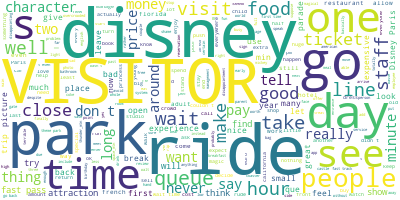

In [ ]:
# Import the wordcloud library
from wordcloud import WordCloud
# Join the different processed titles together.
long_string = ','.join(list(disney_neg['lemma_reviews'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
# We are using the word cloud to figure out which extra stopwords to add to our stopword bank 
wordcloud.to_image()